In [6]:
import tensorflow as tf
import numpy as np
import random


class ExperienceReplay:
    '''
    During gameplay all the states, actions, rewards, and new states are stored
    '''
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def add(self, s1, a, r, s2, done):
        '''
        Add the state, action, reward, and new state to the memory
        return 1 if full otherwise 0
        '''
        self.memory.append([s1, a, r, s2, done])
        if len(self.memory) > self.max_memory:
            return 1
        return 0
    
    def sample(self, n=90):
        '''
        Randomly sample a batch of size n from memory
        '''
        n = min(n, len(self.memory))
        # random.shuffle(self.memory)
        ret = self.memory[:n]
        self.memory = self.memory[n:]
        return ret
    
    def __len__(self):
        return len(self.memory)


class PolicyNetwork:
    def __init__(self, 
                 model, 
                #  target_model, 
                 env, 
                 exp_replay, 
                 step_size=0.9,  
                 gamma=0.99,  
                 batch_size=90, 
                 frequency=10, 
                 tau=1, 
                 epsilon=0.2, 
                 max_time=200,
                 show_video=False,
                 loss_fn = tf.keras.losses.MSE,
                 lr = 0.001):
        
        self.model = model
        # self.target_model = target_model
        self.env = env
        self.exp_replay = exp_replay
        self.batch_size = batch_size
        self.tau = tau
        self.epsilon = epsilon
        self.gamma = gamma
        self.frequency = frequency
        self.step_size = step_size
        self.max_time = max_time
        self.priority_level = 10
        self.show_video = show_video
        self.loss_fn = loss_fn
        self.lr = lr
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)

        self.history = []


    def discount_reward(self, rewards):
        discounted_rewards = []
        cumulative_rewards = 0
        for reward in rewards[::-1]:
            cumulative_rewards = reward + self.gamma * cumulative_rewards
            discounted_rewards.append(cumulative_rewards)
        return np.array(discounted_rewards[::-1])
    
    def train(self, epochs=1000):
        for epoch in range(epochs):
            state = self.env.reset()[0]
            done = False
            t = 0
            reward = 0
            while not done and t<self.max_time:
                t += 1
                action_probs = self.model(np.array([state]))[0]
                action = np.random.choice(np.arange(self.env.action_space.n), p=np.array(action_probs))
                next_state, r, done, truncated, info = self.env.step(action)
                # describing reward 
                if r == -1:
                    reward += r
                else : 
                    reward += 500000
                self.exp_replay.add(state, action, reward, next_state, done)
                state = next_state

            self.history.append(t)
            if epoch % 100 == 0:
                print(f'Epoch: {epoch}, Time: {t}')
            
            if len(self.exp_replay) > self.batch_size:
                train_batch = self.exp_replay.sample(self.batch_size)
                s1_batch = np.array([x[0] for x in train_batch])
                a_batch = np.array([x[1] for x in train_batch])   
                r_batch = np.array([x[2] for x in train_batch])
                # s2_batch = np.array([x[3] for x in train_batch])
                # done_batch = np.array([x[4] for x in train_batch])

                discounted_rewards = self.discount_reward(r_batch)

                with tf.GradientTape() as tape:
                    pred_batch = self.model(s1_batch, training=True)
                    prob_batch = tf.gather_nd(pred_batch , indices=[[i,j] for i,j in enumerate(a_batch)])
                    loss = -tf.reduce_sum(discounted_rewards * tf.math.log(prob_batch))

                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))


                

In [13]:
import gymnasium as gym
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

env = gym.make('Acrobot-v1')

inp = Input(shape=(6,))
x = Dense(200, activation='relu')(inp)
x = Dense(200, activation='relu')(x)
# x = Dense(200, activation='relu')(x)
out = Dense(3, activation='softmax')(x)
model = Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001))

exp_replay = ExperienceReplay(max_memory=300)
# traget_net = TargetNetwork(model)
agent = PolicyNetwork(model, env, exp_replay, batch_size=100, max_time=200, gamma=0.99)


In [23]:
agent.train(100)

Epoch: 0, Time: 80


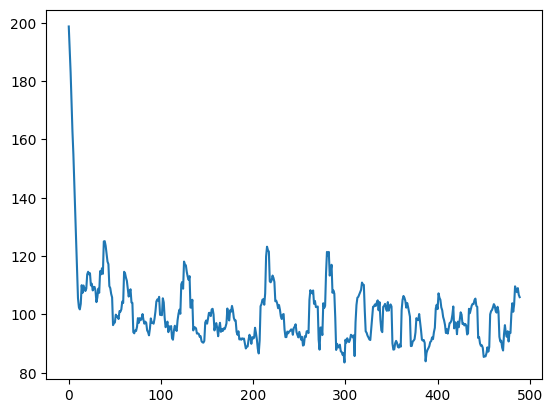

In [25]:
avg_sum = []
for i in range(len(agent.history)-10):
    avg_sum.append(np.mean(agent.history[i:i+10]))
plt.plot(avg_sum)
plt.show()

In [18]:
import pickle 
with open('acrobot_policy_network.pkl', 'wb') as f:
    pickle.dump(agent.model, f)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......input_layer
.........vars
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-06-23 23:14:58       184136
metadata.json                                  2023-06-23 23:14:58           64
config.json                                    2023-06-23 23:14:58         2512
